In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append('../ipa/src/')
import preprocessing_utils as pre
import localization_utils as loc
import detection_utils as det
import nd2
import correction_utils as cor

# Open the image

In [7]:
im = nd2.imread("/tungstenfs/scratch/ggiorget/kristina/Microscopy/20240422/20240422_beads_100ms_7%laser_001.nd2")

In [63]:
met = nd2.ND2File("/tungstenfs/scratch/ggiorget/kristina/Microscopy/20240422/20240422_beads_100ms_7%laser_001.nd2")
met.voxel_size()

VoxelSize(x=0.13, y=0.13, z=0.2)

In [100]:
im.shape

(21, 2, 976, 976)

In [145]:
df = pd.DataFrame(met.events())

In [149]:
df['dt'] = df['Time [s]'].diff()

In [151]:
df.dt.mean()

0.6901304443359375

In [8]:
im = im[:, 1:3, ...]

In [9]:
im.shape

(21, 2, 976, 976)

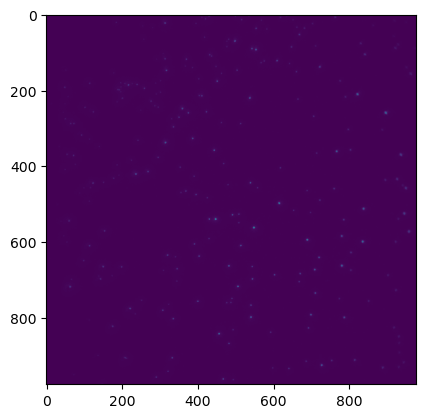

In [11]:
plt.imshow(im[10, 0, ...])

# Detect the beads

In [42]:
im_c1 = im[:, 0, ...]
im_c2 = im[:, 1, ...]

In [21]:
h = pre.compute_h_param(im=im_c1,frame = im_c1.shape[0]//2)

/tungstenfs/scratch/ggiorget/nessim/miniconda3/envs/cohesin_analysis/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/tungstenfs/scratch/ggiorget/nessim/miniconda3/envs/cohesin_analysis/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [40]:
h2 = pre.compute_h_param(im=im_c2,frame = im_c2.shape[0]//2)

/tungstenfs/scratch/ggiorget/nessim/miniconda3/envs/cohesin_analysis/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/tungstenfs/scratch/ggiorget/nessim/miniconda3/envs/cohesin_analysis/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [41]:
print(h,h2)

1699.9679006751521 1471.1493195403382


In [43]:
im_c1 = np.expand_dims(im_c1, axis=0)
im_c2 = np.expand_dims(im_c2, axis=0)

In [44]:
detections = det.hmax_3D(raw_im= im_c1,frame=0,sd=h,n = 1,thresh = 0.5,threads = 10)
detections_temp = det.hmax_3D(raw_im= im_c2,frame=0,sd=h2,n = 1,thresh = 0.5,threads = 10)

Runtime


In [45]:
detections['channel'] = 1
detections_temp['channel'] = 2

detections = pd.concat([detections, detections_temp])

In [46]:
detections

,x,y,z,sd_fit_x,sd_fit_y,sd_fit_z,frame,channel
0,759.025872,460.486344,8.923306,0.069816,0.088013,0.043676,0,1
1,301.533192,205.636450,11.633350,0.049728,0.049892,0.039751,0,1
2,251.595825,755.044519,11.808733,0.053025,0.056680,0.042526,0,1
3,359.318171,249.689212,10.982969,0.073392,0.092374,0.050825,0,1
4,955.883993,573.825650,7.768187,0.070953,0.122333,0.034689,0,1
...,...,...,...,...,...,...,...,...
258,503.043876,148.653951,10.136832,0.086879,0.122655,0.050621,0,2
259,226.397962,182.591301,12.363473,0.060837,0.060813,0.060152,0,2
260,943.745939,525.646116,8.420339,0.078238,0.121615,0.061635,0,2
261,691.489744,827.997035,10.010543,0.078473,0.084373,0.052869,0,2


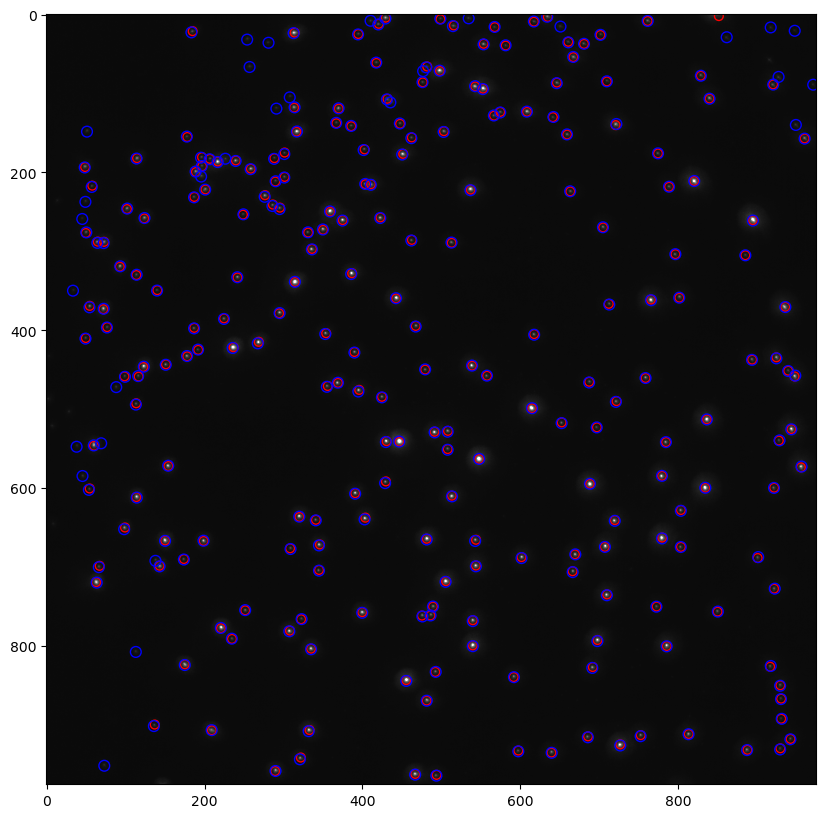

In [48]:
plt.figure(figsize=(10,10))
plt.imshow(np.max(im_c1[0, :, ...],axis=0), cmap='gray', vmin=0, vmax=10000)
plt.scatter(detections[detections.channel == 1]['x'],detections[detections.channel == 1]['y'], edgecolors='r',facecolors='none' ,s=40)
plt.scatter(detections[detections.channel == 2]['x'],detections[detections.channel == 2]['y'], edgecolors='blue',facecolors='none' ,s=60)

# Matching

In [64]:
detections['x'] = detections['x']*met.voxel_size()[0]
detections['y'] = detections['y']*met.voxel_size()[1]
detections['z'] = detections['z']*met.voxel_size()[2]

In [134]:
detections_f = detections#.query('x > 32 and x < 84 and y > 32 and y < 84')

In [135]:
matched = cor.assign_closest(detections_f[detections_f.channel ==1],detections_f[detections_f.channel ==2],0.2)

In [136]:
detections_1 = detections_f[detections_f.channel == 1].copy()
detections_2 = detections_f[detections_f.channel == 2].copy()

In [137]:
for i in matched:
    # print(i)
    # break
    detections_1.loc[i[0],'dx'] = i[3][0]
    detections_1.loc[i[0],'dy'] = i[3][1]
    detections_1.loc[i[0],'dz'] = i[3][2]

In [138]:
detections_1.dropna(inplace=True, axis=0)

In [139]:
matched = np.array(matched)

/scratch/louaness/ipykernel_21431/4078686233.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  matched = np.array(matched)


In [140]:
d = np.vstack(matched[:,3])


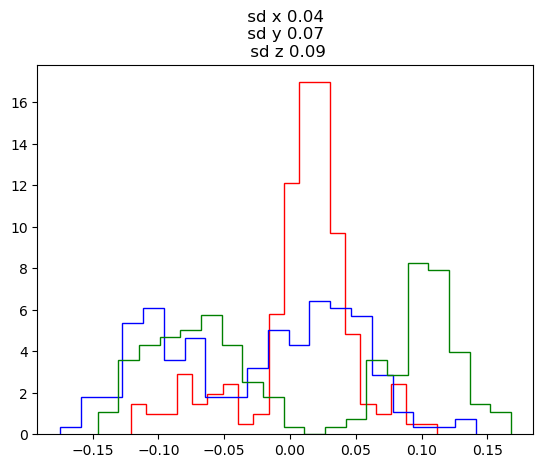

In [141]:
plt.hist(d[:,0],histtype='step',color='r',bins=20,density=True)
plt.hist(d[:,1],histtype='step',color='blue',bins=20,density=True)
plt.hist(d[:,2],histtype='step',color='green',bins=20,density=True)
plt.title(f' sd x {np.std(d[:,0]):,.2f} \n sd y {np.std(d[:,1]):,.2f} \n sd z {np.std(d[:,2]):,.2f}')
plt.show()

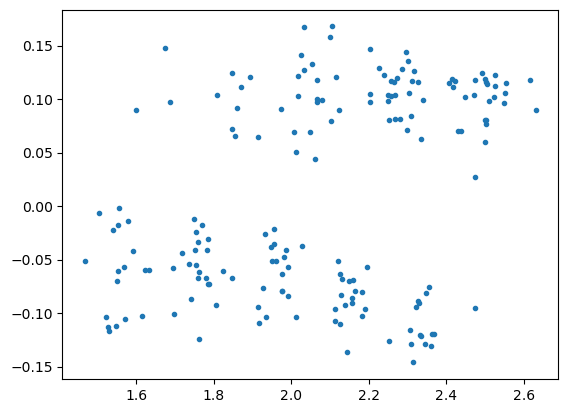

In [142]:
plt.scatter(detections_1['z'],detections_1['dz'], marker='.')


(-1.3, 1.3)

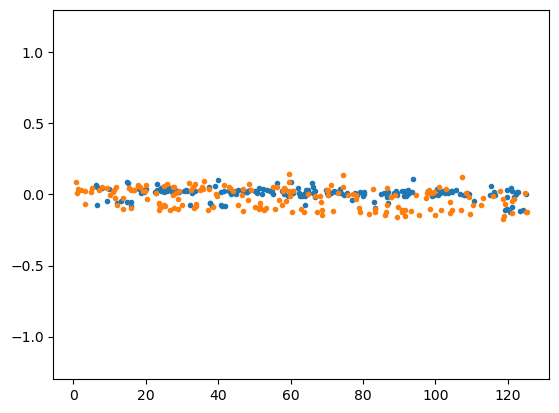

In [143]:
plt.scatter(detections_1['x'],detections_1['dx'], marker='.')
plt.scatter(detections_1['y'],detections_1['dy'], marker='.')
plt.ylim(-1.3,1.3)